<a href="https://colab.research.google.com/github/MerArch/Quantitativecommodityresearch/blob/main/A_B_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Fast Food Marketing Campaign A\B Test##
##Scenario

A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.

##Goal

Evaluate A/B testing results and decide which marketing strategy works the best.

##Columns

MarketID: unique identifier for market

MarketSize: size of market area by sales

LocationID: unique identifier for store location

AgeOfStore: age of store in years

Promotion: one of three promotions that were tested

week: one of four weeks when the promotions were run

SalesInThousands: sales amount for a specific LocationID, Promotion, and week


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
pd.set_option('display.max_rows', 50)
import warnings
import plotly.express as px
from datetime import datetime, date
warnings.filterwarnings("ignore")


import statsmodels.stats.api as sms
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro, levene, kruskal
from statsmodels.stats.multicomp import MultiComparison
!pip install scikit-posthocs
import scikit_posthocs as sp

In [ ]:
main_data = pd.read_csv('/content/WA_Marketing-Campaign_ABTESTINGDATA.csv')
main_data

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81
...,...,...,...,...,...,...,...
543,10,Large,919,2,1,4,64.34
544,10,Large,920,14,2,1,50.20
545,10,Large,920,14,2,2,45.75
546,10,Large,920,14,2,3,44.29


##Data Cleaning
* Change column names to lower case

In [ ]:
#Change column names
# The lower() method returns a string where all characters are lower case.
# Symbols and Numbers are ignored.
main_data.columns = [i.lower() for i in main_data.columns]
main_data.columns

Index(['marketid', 'marketsize', 'locationid', 'ageofstore', 'promotion',
       'week', 'salesinthousands'],
      dtype='object')

* Check the shape of the data

In [ ]:
#Check data shape
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   marketid          548 non-null    int64  
 1   marketsize        548 non-null    object 
 2   locationid        548 non-null    int64  
 3   ageofstore        548 non-null    int64  
 4   promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   salesinthousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


* Check for missing values

In [ ]:
#Check missing values
main_data.isnull().sum()

marketid            0
marketsize          0
locationid          0
ageofstore          0
promotion           0
week                0
salesinthousands    0
dtype: int64

* Check for duplicate values

In [ ]:
#Check duplicate values
main_data.duplicated().sum()

0

# Check for data accuracy
### Definition and Usage
The select_dtypes() method returns a new DataFrame that **includes/excludes **columns of the specified dtype(s).

Use the include parameter to specify the included columns, or use the exclude parameter to specify which columns to exclude

Note: You must specify at least one of the parameters include and/or exclude, or else you will get an error.

* The enumerate() function takes a collection (e.g. a tuple) and returns it as an enumerate object.
* The enumerate() function adds a counter as the key of the enumerate object.
### Syntax
* enumerate(iterable, start)
### Parameter Values
##### Parameter	Description
* iterable	An iterable object
* start	A Number. Defining the start number of the enumerate object. Default 0

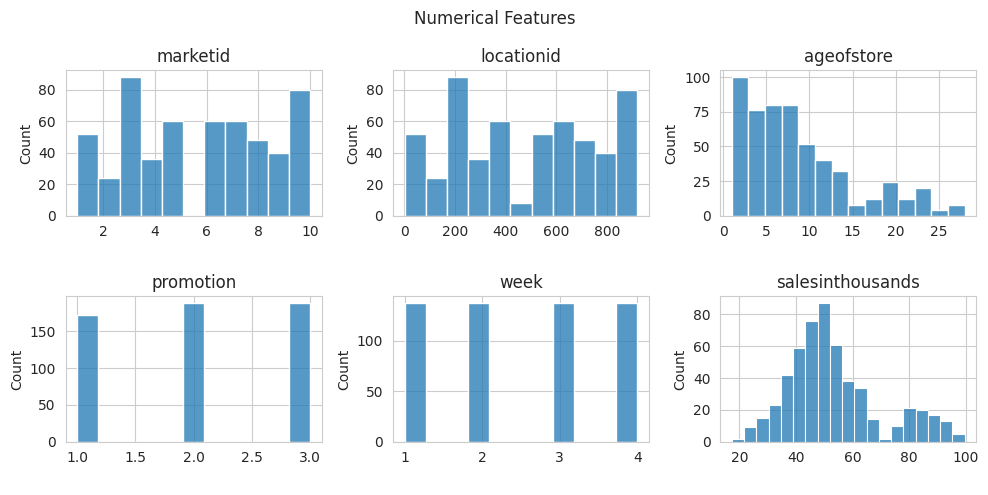

In [ ]:
#Check data accuracy
num_col = main_data.select_dtypes(['int64','float64'])

# The select_dtypes() method returns a new DataFrame that includes/excludes columns of the specified dtype(s).

fig = plt.figure(figsize = (10,5))
fig.suptitle('Numerical Features')
for i,j in enumerate(num_col):
    ax = fig.add_subplot(2,3,i+1)
    ax = sns.histplot(main_data , x = j)
    ax.set_title(j)
    ax.set_xlabel(' ')
plt.tight_layout()
plt.show()

* Explore on the marketsize column data for categorical plot

Text(0.5, 1.0, 'Categorical Feature')

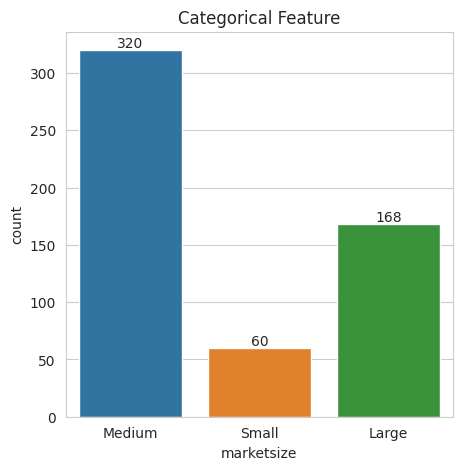

In [ ]:
fig = plt.figure(figsize = (5,5))
ax = sns.countplot(main_data , x = 'marketsize')
ax.bar_label(ax.containers[0])
plt.title('Categorical Feature')

* Summary
* It seems there are no anomalies in this dataset.  means that the summary statistics do not show any extreme or unusual values (outliers) that might indicate data quality issues or anomalies. The data appears to be within expected ranges for the variables *italicised text*

In [ ]:
main_data.describe().T


,count,mean,std,min,25%,50%,75%,max
marketid,548.0,5.715328,2.877001,1.00,3.000,6.0,8.0000,10.00
locationid,548.0,479.656934,287.973679,1.00,216.000,504.0,708.0000,920.00
ageofstore,548.0,8.503650,6.638345,1.00,4.000,7.0,12.0000,28.00
promotion,548.0,2.029197,0.810729,1.00,1.000,2.0,3.0000,3.00
week,548.0,2.500000,1.119055,1.00,1.750,2.5,3.2500,4.00
salesinthousands,548.0,53.466204,16.755216,17.34,42.545,50.2,60.4775,99.65


## Exploring datset by performance metric¶


Text(0, 0.5, 'Sales')

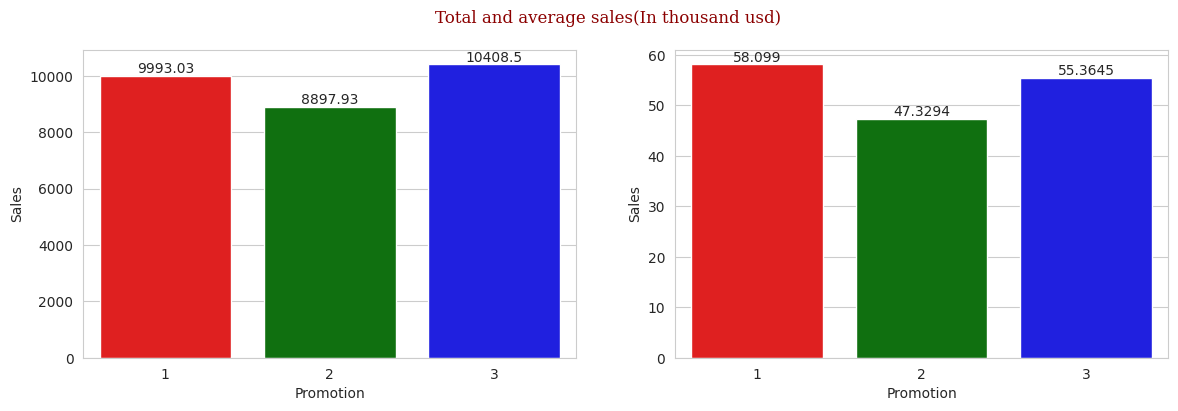

In [ ]:
promo = main_data.groupby('promotion',as_index = False).agg(sales_mean = ('salesinthousands','mean') , sales_sum = ('salesinthousands','sum') )
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 13,
        }
colors = ['red', 'green', 'blue']
fig = plt.figure(figsize = (14,4))
plt.suptitle('Total and average sales(In thousand usd)' , fontdict = font)
ax = plt.subplot(1,2,1)
ax = sns.barplot(promo , x = 'promotion' , y = 'sales_sum' , palette = colors)
ax.bar_label(ax.containers[0])
ax.set_xlabel('Promotion')
ax.set_ylabel('Sales')

ax1 = plt.subplot(1,2,2)
ax1 = sns.barplot(promo , x = 'promotion' , y = 'sales_mean',  palette = colors)
ax1.bar_label(ax1.containers[0])
ax1.set_xlabel('Promotion')
ax1.set_ylabel('Sales')

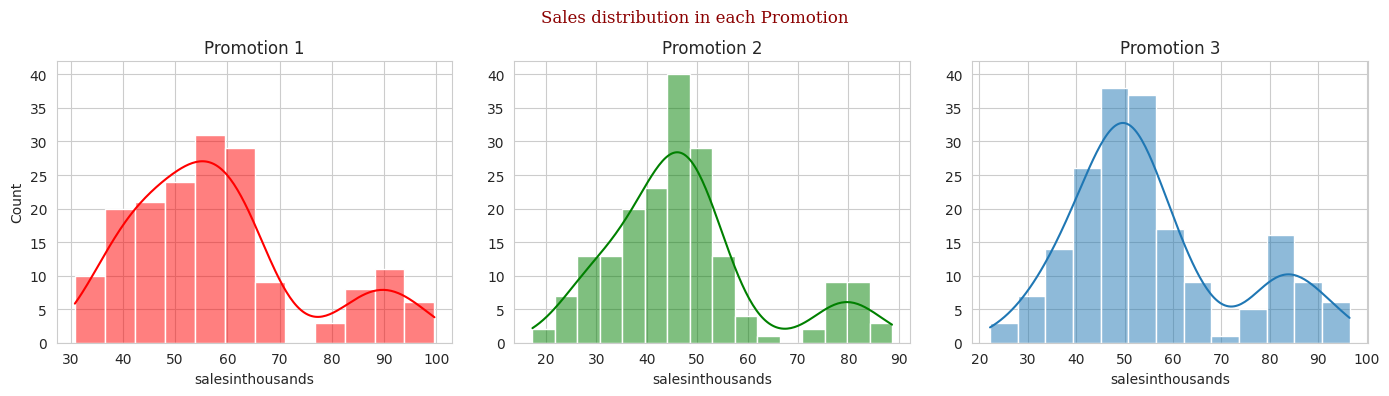

In [ ]:
fig = plt.figure(figsize = (14,4))

plt.suptitle('Sales distribution in each Promotion', fontdict = font)

ax = fig.add_subplot(1,3,1)
ax = sns.histplot(main_data[main_data['promotion'] == 1] , x = 'salesinthousands' , kde = True , color = 'red')
ax.set_title('Promotion 1')

ax2 = fig.add_subplot(1,3,2 , sharey = ax)
ax2 = sns.histplot(main_data[main_data['promotion'] == 2] , x = 'salesinthousands' , kde = True , color = 'green')
ax2.set_title('Promotion 2')
ax2.set_ylabel(' ')

ax3 = fig.add_subplot(1,3,3 , sharey = ax)
ax3 = sns.histplot(main_data[main_data['promotion'] == 3] , x = 'salesinthousands' , kde = True)
ax3.set_title('Promotion 3')
ax3.set_ylabel(' ')

plt.tight_layout()
plt.subplots_adjust(top=0.85)

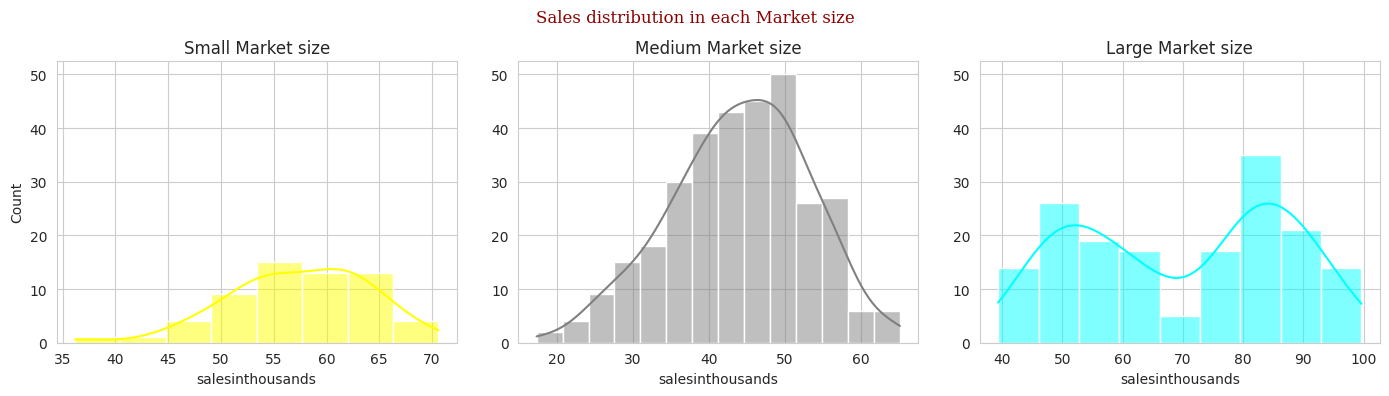

In [ ]:
fig = plt.figure(figsize = (14,4))

plt.suptitle('Sales distribution in each Market size', fontdict = font)

ax = fig.add_subplot(1,3,1)
ax = sns.histplot(main_data[main_data['marketsize'] == 'Small'] , x = 'salesinthousands' , kde = True , color = 'yellow')
ax.set_title('Small Market size')

ax2 = fig.add_subplot(1,3,2 , sharey = ax)
ax2 = sns.histplot(main_data[main_data['marketsize'] == 'Medium'] , x = 'salesinthousands' , kde = True , color = 'grey')
ax2.set_title('Medium Market size')
ax2.set_ylabel(' ')

ax3 = fig.add_subplot(1,3,3 , sharey = ax)
ax3 = sns.histplot(main_data[main_data['marketsize'] == 'Large'] , x = 'salesinthousands' , kde = True , color = 'cyan')
ax3.set_title('Large Market size')
ax3.set_ylabel(' ')

plt.tight_layout()
plt.subplots_adjust(top=0.85)

## Outlier Detection

In [ ]:
def iqrmethod(column , main_data):
    q1 = np.percentile(main_data[column] , 25)
    q3 = np.percentile(main_data[column] , 75)
    IQR = q3-q1
    lower = q1 - (1.5 * IQR)
    upper = q3 + (1.5 * IQR)
    outlier = [i for i in main_data[column] if i > upper or i < lower]
    return outlier

In [ ]:
outlier = iqrmethod(column = 'salesinthousands' , main_data = main_data)
outlier

[88.73,
 94.17,
 89.7,
 87.43,
 88.12,
 90.3,
 89.77,
 88.91,
 87.7,
 94.21,
 96.48,
 91.98,
 93.71,
 96.01,
 93.03,
 97.61,
 88.07,
 94.43,
 89.44,
 88.64,
 87.9,
 91.6,
 93.86,
 94.89,
 93.63,
 91.61,
 99.65,
 88.64,
 89.25,
 89.32,
 99.12,
 93.32,
 91.29]

In [ ]:
main_data = main_data[~main_data['salesinthousands'].isin(outlier)]
main_data

,marketid,marketsize,locationid,ageofstore,promotion,week,salesinthousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81
...,...,...,...,...,...,...,...
543,10,Large,919,2,1,4,64.34
544,10,Large,920,14,2,1,50.20
545,10,Large,920,14,2,2,45.75
546,10,Large,920,14,2,3,44.29


**bold text**# Detect outliers



<Axes: xlabel='salesinthousands'>

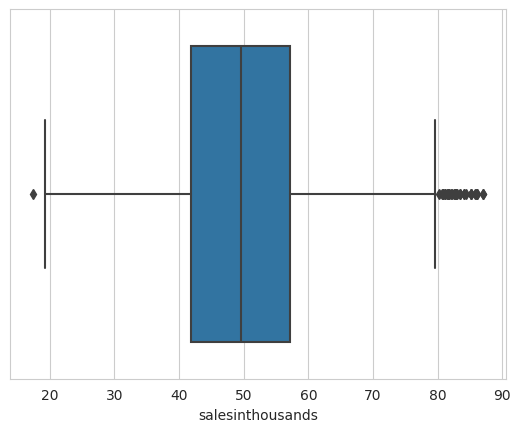

In [ ]:
# Detect outliers
sns.boxplot(main_data , x = 'salesinthousands')

## Normality Check  
* QQ plot

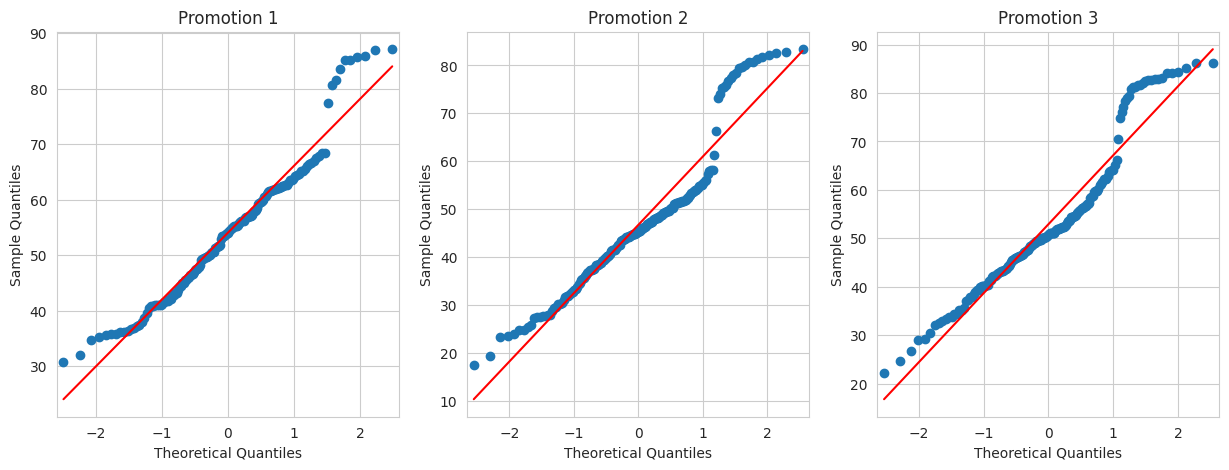

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (15, 5))

qqplot(main_data[main_data["promotion"] == 1]["salesinthousands"], line = "s", ax = axs[0])
qqplot(main_data[main_data["promotion"] == 2]["salesinthousands"], line = "s", ax = axs[1])
qqplot(main_data[main_data["promotion"] == 3]["salesinthousands"], line = "s", ax = axs[2])

axs[0].set_title("Promotion 1")
axs[1].set_title("Promotion 2")
axs[2].set_title("Promotion 3")

plt.show()

#### * In the above plots it seems that none of these groups are normally distributed.

* THey suggest skewness

#Shapiro Test¶

* The null hypothesis (H0) assumes that the data is normally distributed, while the alternative hypothesis (Ha) assumes that the data is not normally distributed.


In [ ]:
promotions = main_data["promotion"].unique()

for promotion in promotions:

    p_value = shapiro(main_data[main_data["promotion"] == promotion]["salesinthousands"])[1]

    print("Promotion : {} \t P-value : {} \t Reject H_0: {}".format(promotion, p_value, p_value<0.05))

Promotion : 3 	 P-value : 2.2533025401116902e-07 	 Reject H_0: True
Promotion : 2 	 P-value : 1.5782022799726292e-08 	 Reject H_0: True
Promotion : 1 	 P-value : 0.00011412142339395359 	 Reject H_0: True


### * We reject null hypothesis meaning that sales in each promotion are not normally distributed.

#Homogeneity of variance check¶

* The null hypothesis (H0) assumes equal variances among the groups, while the alternative hypothesis (Ha) assumes unequal variances.


In [ ]:
# levene test for homogeneity.
test_stat, p_value = levene(main_data[main_data["promotion"] == 1]["salesinthousands"],
                            main_data[main_data["promotion"] == 2]["salesinthousands"],
                            main_data[main_data["promotion"] == 3]["salesinthousands"])

print("P-value : {} \t H_0 reject : {}".format(p_value, p_value<0.05))

P-value : 0.5551371801721181 	 H_0 reject : False


## * We fail to reject the null hypothesis meaning that sales in each promotion have equal variances.

#Non-parametric ANOVA Test , Kruskal Wallis Test

* We will proceed to use non-parametric test since our data violated the normality assumption.
* The null hypothesis of the Kruskal-Wallis test is that the population medians of all groups are equal.


In [ ]:
test_stat, p_value = kruskal(
                            main_data[main_data["promotion"] == 1]["salesinthousands"],
                            main_data[main_data["promotion"] == 2]["salesinthousands"],
                            main_data[main_data["promotion"] == 3]["salesinthousands"]
)

print("P-value : {} \t H_0 reject : {}".format(p_value, p_value<0.05))

P-value : 1.4058149891804454e-09 	 H_0 reject : True


## * We reject the null hypothesis meaning that at least one group differs in median from the others.

#Post-hoc Dunn's Test
* Now we want to know which groups are different from each other, so we will perform post-hoc Dunn's test

* The null hypothesis for each pairwise comparison in Dunn's test is that there is no difference between the medians of the two groups being compared.

* The alternative hypothesis is that there is a significant difference between the medians.

In [ ]:
promotion_1 = main_data[main_data["promotion"] == 1]["salesinthousands"]
promotion_2 = main_data[main_data["promotion"] == 2]["salesinthousands"]
promotion_3 = main_data[main_data["promotion"] == 3]["salesinthousands"]

data_promotions = [promotion_1, promotion_2, promotion_3]

sp.posthoc_dunn(data_promotions, p_adjust = 'bonferroni')

,1,2,3
1,1.000000e+00,4.647277e-09,0.390555
2,4.647277e-09,1.000000e+00,0.000009
3,3.905554e-01,9.017030e-06,1.000000


* p-value between promotion 1 and 2 is 4.647277e-09 which is less than 0.05. Therefore, there is a difference between promotion 1 and promotion 2.

* p-value between promotion 2 and 3 is 0.000009 which is less than 0.05. Therefore, there is a difference between promotion 3 and promotion 2.

* p-value between promotion 1 and 3 is 0.390555 which is greater than 0.05. Therefore, there is no difference between promotion 1 and promotion 3.

#Summary

* Now we can conclude that promotion one and three gives no different results and these two promotions yield better sales more than promotion two.

In [ ]:
promo.set_index(keys = 'promotion')

,sales_mean,sales_sum
promotion,,
1,58.099012,9993.03
2,47.329415,8897.93
3,55.364468,10408.52
